# Определение возраста покупателей

## Задача:
Заказчик: сетевой супермаркет. Необходимо построить модель, которая будет определять возраст покупателя по фото. Это поможет заказчику построить рекомендательную систему соответсвующих товаров. Вторая задача, которая будет решаться с помощью этой модели, контролировать отвественное отношение кассиров к продаже алкоголя несовершеннолетним.
<br><br>
В распоряжении находится датасет из фотографий и соответствующих им возрастов покупателей. На основе этого даасета нужно обучить модель, которая будет выдавать ошибку MAE < 8.


## Исследовательский анализ данных

In [ ]:
# < Перенесите сюда исследовательский анализ данных ># Исследовательский анализ данных

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns


In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)



Found 7591 validated image filenames.


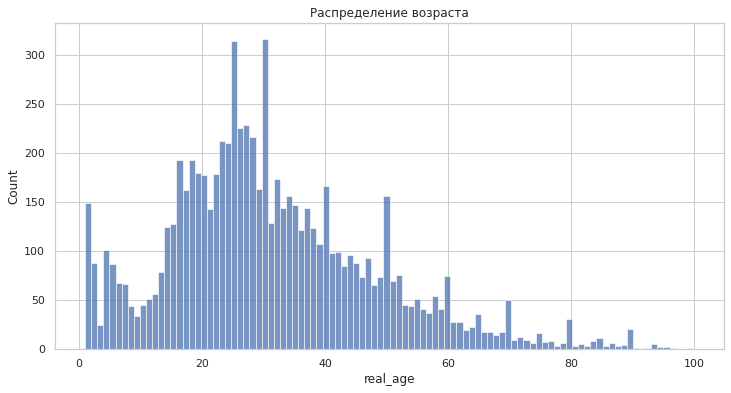

In [ ]:
plt.figure(figsize=(12,6))
sns.set_theme()
sns.set_style("whitegrid")
sns.histplot(labels['real_age'], bins=100, palette="hls").set(title='Распределение возраста')
plt.show()

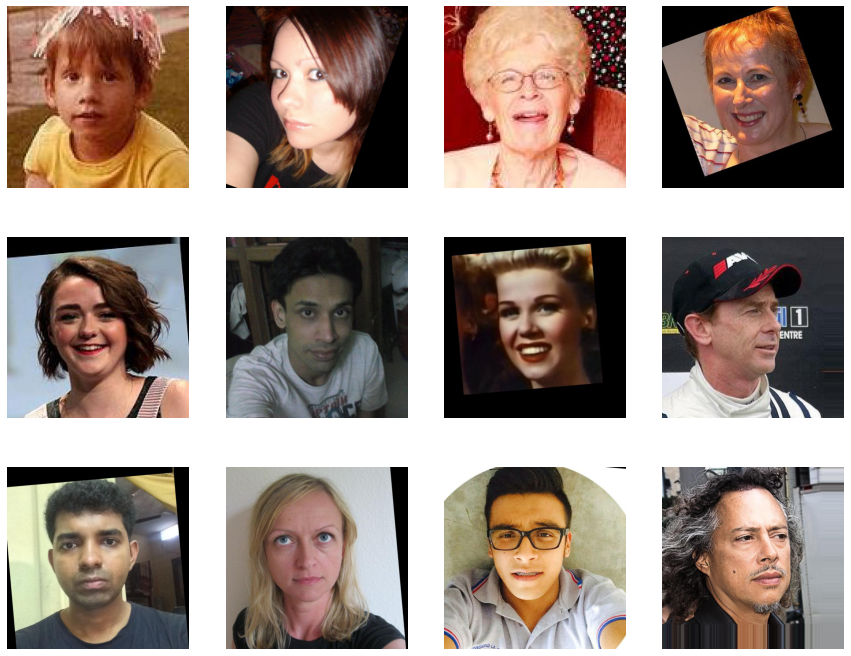

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.2)

for i in range(0, 12):
    path = '/datasets/faces/final_files/' + labels['file_name'][i]
    image = Image.open(path)
    array = np.array(image)
    plt.subplot(3, 4, i + 1)
    plt.imshow(array);
    plt.axis('off')

plt.show()

### Вывод:
Датасет содержит 7,5 тысяч файлов, возраст людей имеет приближенное к нормальному распределение с увеличенным количеством фотографий в возрасте до 10 лет (особенно много фото детей до 3 лет), то вероятно поможет лучше идентифицировать возраст детей, когда их внешность очень быстро меняется. Также фото людей возраста 80 и выше достаточно мало, так что можно сказать, что датасет вполне сбалансирован и даст шанс модели хорошо обучиться. Фото предсавлены в разных вариантах, похоже, что почти все они были повернуты так, чтобы лицо было располежено ровно. <br>
Судить о том, достаточно ли фото для обучения, получится уже после попытки обучить модели и получить метрики качества.


## Обучение модели

Обучение модели проводилось на отдельном сервере, поэтому здесь приведен код функций, которые вызывались на стороне сервера для получения результата, приведенного в следующей ячейке.

```python


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

optimizer = Adam(lr=0.0001)

def load_train(path):
    labels = pd.read_csv(f'{path}labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255,
                                       horizontal_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=f'{path}/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=12345)
    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(f'{path}labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=f'{path}/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            seed=12345)
    return test_gen_flow


def create_model(input_shape):
       
    resnet = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(resnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,  
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```



Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-05-14 19:57:53.459837: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-14 19:57:53.831358: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 52s - loss: 261.3175 - mae: 11.4713 - val_loss: 465.9267 - val_mae: 16.4964
Epoch 2/10
178/178 - 44s - loss: 78.6632 - mae: 6.6508 - val_loss: 627.6144 - val_mae: 20.0165
Epoch 3/10
178/178 - 45s - loss: 52.6673 - mae: 5.4875 - val_loss: 275.1930 - val_mae: 12.2990
Epoch 4/10
178/178 - 45s - loss: 38.9942 - mae: 4.6894 - val_loss: 104.1447 - val_mae: 7.7809
Epoch 5/10
178/178 - 43s - loss: 27.8273 - mae: 4.0349 - val_loss: 78.0892 - val_mae: 6.6840
Epoch 6/10
178/178 - 43s - loss: 21.3993 - mae: 3.5725 - val_loss: 78.0739 - val_mae: 6.5439
Epoch 7/10
178/178 - 45s - loss: 17.0784 - mae: 3.1549 - val_loss: 63.9317 - val_mae: 6.0262
Epoch 8/10
178/178 - 44s - loss: 13.7718 - mae: 2.8305 - val_loss: 82.0486 - val_mae: 6.7825
Epoch 9/10
178/178 - 44s - loss: 11.4729 - mae: 2.5907 - val_loss: 62.7679 - val_mae: 5.9607
Epoch 10/10
178/178 - 42s - loss: 10.3753 - mae: 2.4418 - val_loss: 67.5073 - val_mae: 6.0434
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 67.5073 - mae: 6.0434
Test MAE: 6.0434

```

## Анализ обученной модели

### Вывод:
Была использована модель ResNet50 с последним слоем, состоящим из 1 нейрона, т.к мы решали задачу регрессии, а не классификации. В качестве функции активации использовался ReLU, позволяющий отрезать отрицательные значеия, которые невозможны при определении возраста. Также за базовые веса были взяты веса из ImageNet. Для увеличения выборки было добавлено вертикальное отражение. <br><br>
Модель достаточно быстро обучилась и за 10 эпох смогла показать желаемый результат с MAE ~ 6 на тестовом наборе данных.  